# Проект: Определение возраста покупателей по фотографии

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - контролировать добросовестность кассиров при продаже алкоголя.
 
**Задача:** Построить модель, которая по фотографии определит приблизительный возраст человека.

**Цель:** Добиться значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [1]:
# Стандартные библиотеки
import pandas as pd
import matplotlib.pyplot as plt

# Импорт внешних библиотек
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')

Взглянем на общую информацию о датасете

In [3]:
def review(df):
    display(df.head())
    print('------------')
    display(df.info())
    print('------------')
    display(df.shape)  

review(df_labels)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

------------


(7591, 2)

**Вывод:** Взглянув на данные видно, что в датасете содержится информация о "реальном возрасте" и "названии файлов". Данные содержатся в 7591 строках и 2 колонках. Типы данных в колонках соответствсуют ожиданиям.

Загрузим фотографии из директории: */final_files* в **Train** и **Test** выбоки

**Train выборка**

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25)

train_data = train_datagen.flow_from_dataframe(
    df_labels,
    x_col='file_name',
    y_col='real_age',
    directory='/datasets/faces/final_files',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)

Found 5694 validated image filenames.


**Test выборка**

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split=0.25)

test_data = test_datagen.flow_from_dataframe(
    df_labels,
    x_col='file_name',
    y_col='real_age',
    directory='/datasets/faces/final_files',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)

Found 1897 validated image filenames.


Посмотрим на размер одного батча

In [6]:
features, target = next(train_data)

display(features.shape)

(32, 224, 224, 3)

**Вывод:** Один батч состоит из 32 изображений размером 224x224 с тремя цветовыми каналами.

### Визуализируем данные:

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


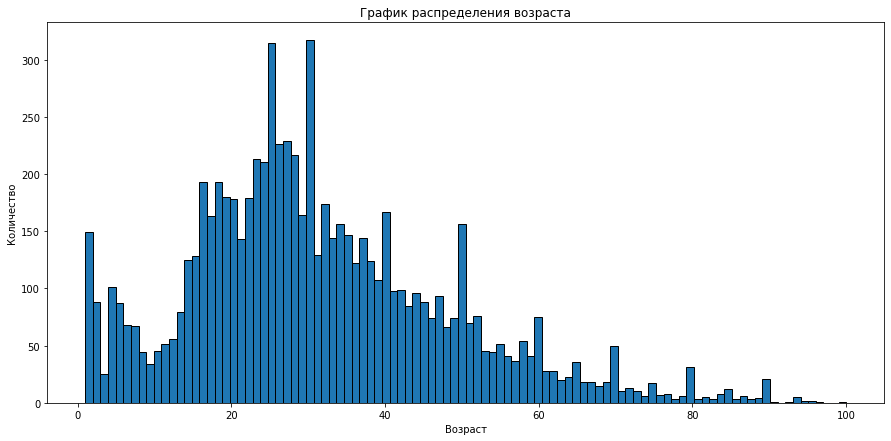

In [7]:
plt.figure(figsize=(15, 7))
plt.hist(df_labels['real_age'], bins=100, edgecolor="black")
plt.title('График распределения возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество');
df_labels.describe()

**Вывод:** Гистограмма распределения возраста показала, что большая часть значений находится в диапазоне от 20 до 41 года.

Из гистограммы видно два максимума:

Это фотографии детей от 1 года - 9 лет (пиковое значение на этом уровне связано с "быстрыми" визуальными изменениями младенцев, чтобы нейросети было проще обущаться)
Второй максимум приходится на возраст 25 лет, и после 30 лет каждые десять лет заметны всплески количества фотографий (Я думаю, что такое распределение помогает модели обучаться)

Выведем 16 фотографий датасета

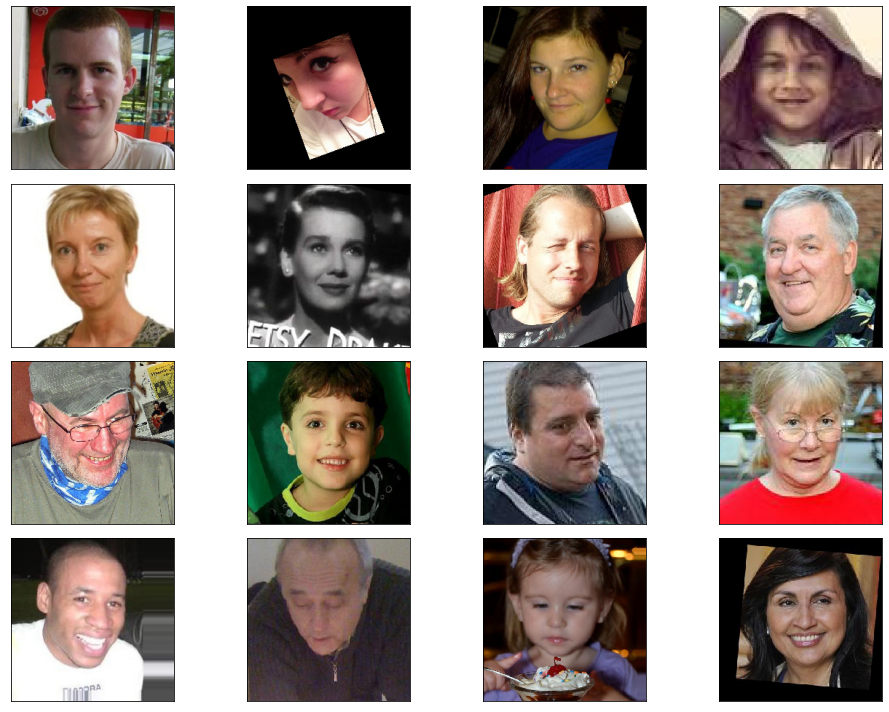

In [8]:
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

Датасет сожержит 7591 фотографии

Гистограмма распределения возраста показала, что большая часть значений находится в диапазоне от 20 до 41 года. 

Из гистограммы видно два максимума: 
* Это фотографии детей от 1 года - 9 лет (пиковое значение на этом уровне связано с "быстрыми" визуальными изменениями младенцев, чтобы нейросети было проще обущаться) 
* Второй максимум приходится на возраст 25 лет, и после 30 лет каждые десять лет заметны всплески количества фотографий (Я думаю, что такое распределение помогает модели обучаться)

В нашем датасете присутствуют:
1. Как цветные, так и черно-белые фотографии;
2. Большая часть фотографий имееют вертикальную ориентацию с расположением лица по центру фотографии.
3. Присутствует значительное количество фотографий, на которых лица изображены под углом (Полуанфас)
4. некоторые фотографии отличаются качеством, какие-то лучше, какие-то хуже.

В части выбора аугментации, для улучшения качества нейросети рекомендую использовать - горизонтальную аугментацию т.к. на большем числе фотографий лица расположены в полуанфас.

## Обучение модели

```python


def load_train(path):
    df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    train_datagen = ImageDataGenerator(rescale=1./255,  
                                       validation_split=0.25,
                                       horizontal_flip=True)
    train_data = train_datagen.flow_from_dataframe(
                 df_labels,
                 x_col='file_name', 
                 y_col='real_age',
                 directory=os.path.join(path, 'final_files/'), 
                 target_size=(224, 224), 
                 batch_size=32,  
                 class_mode='raw', 
                 subset='training', 
                 seed=12345)

    return train_data




def load_test(path):
    df_labels = pd.read_csv(os.path.join(path, 'labels.csv'))
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                      validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
                df_labels,
                x_col='file_name', 
                y_col='real_age',
                directory=os.path.join(path, 'final_files/'), 
                target_size=(224, 224), 
                batch_size=32,  
                class_mode='raw', 
                subset='validation',
                seed=12345)

    return test_data




def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

    return model




def train_model(model, train_data, test_data,
                batch_size=None, epochs=6,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 55s - loss: 220.0327 - mean_absolute_error: 10.5519 - val_loss: 984.9194 - val_mean_absolute_error: 26.6572
Epoch 2/6
178/178 - 46s - loss: 73.1624 - mean_absolute_error: 6.4429 - val_loss: 886.4917 - val_mean_absolute_error: 24.9047
Epoch 3/6
178/178 - 45s - loss: 48.2178 - mean_absolute_error: 5.2717 - val_loss: 419.7653 - val_mean_absolute_error: 15.4827
Epoch 4/6
178/178 - 45s - loss: 36.8060 - mean_absolute_error: 4.5766 - val_loss: 98.1061 - val_mean_absolute_error: 7.4292
Epoch 5/6
178/178 - 45s - loss: 27.1062 - mean_absolute_error: 3.9601 - val_loss: 74.0305 - val_mean_absolute_error: 6.4686
Epoch 6/6
178/178 - 45s - loss: 20.9930 - mean_absolute_error: 3.4985 - val_loss: 64.6505 - val_mean_absolute_error: 6.0189

60/60 - 11s - loss: 64.6505 - mean_absolute_error: 6.0189
````
**Test MAE: 6.0189**

## Анализ обученной модели

В данном проекте мы обучили предобученную нейросеть ResNet c 50 слоями нейронов, на датасете с фотографиями людей. 

Учитывая объем нашего датасета, для достижения требуемого качества нейросети, мы использовали метод "backbone" без заморозки весов на предобученной Imagenet сети.
Так как перед нами стояла задача регрессии: *предсказание возраста по фото*. Функцию потерь мы использовали MSE, а метрика качества была MAE. В выходном слое нейросети всего 1 нейрон, который возвращает число-предсказание. 
Для улучшения качества нейросети мы применили метод аугментации - отражение по горизонтали.


Наша целевая **метрика МАЕ** всего за 6 эпох стала равна **6.0189**. На данном количестве эпох переобучения не наблюдалось, возможно если увеличить количество эпох, модель начнет переобучаться.
 
**Целевой показатель: метрика МАЕ<8**, был достигнут на 4-й эпохе. 

Модель можно использовать для предсказания возраста наших покупателей на кассе, внедрив ее в соответствующую систему фотофиксации.